In [388]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans # k-means
from sklearn.pipeline import Pipeline

from sklearn.metrics import silhouette_score

%matplotlib inline

#https://www.kaggle.com/geomack/spotifyclassification

In [389]:
spotify = pd.read_csv('/Users/willstrauss/Documents/Data_Science/Data/Spotify.csv')

In [390]:
spotify.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [391]:
spotify.drop(spotify.columns[0], axis='columns', inplace=True)

In [392]:
spotify.shape

(2017, 16)

In [393]:
predictors = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
              'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'target']

z = StandardScaler()

spotify[predictors] = z.fit_transform(X)

## Principle Component Analysis

In [394]:
pca = PCA()
pca.fit(spotify[predictors])

pcaDF = pd.DataFrame({'expl_var': pca.explained_variance_ratio_, 
                      'component': range(1,15), 
                      'cum_variance': pca.explained_variance_ratio_.cumsum()})

pcaDF

,expl_var,component,cum_variance
0,0.203513,1,0.203513
1,0.111744,2,0.315257
2,0.104852,3,0.420109
3,0.080380,4,0.500489
4,0.078238,5,0.578726
5,0.072739,6,0.651465
6,0.064788,7,0.716253
7,0.057184,8,0.773438
8,0.053626,9,0.827064
9,0.051434,10,0.878498


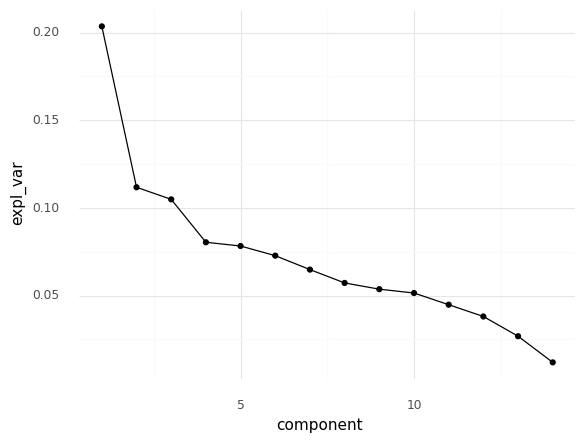

<ggplot: (8764198123517)>

In [395]:
ggplot(pcaDF, aes(x = 'component', y = 'expl_var')) + geom_line() + geom_point() + theme_minimal()

In [419]:
spotify_pca = pca.transform(spotify[predictors])
spotify_pca = pd.DataFrame(spotify_pca[:, 1:3])
spotify_pca

,0,1
0,-1.201027,-0.257704
1,-1.173836,-0.212067
2,-1.404712,-1.001239
3,-0.482608,-0.196735
4,-1.243111,2.639905
...,...,...
2012,0.542879,-0.798194
2013,-0.974040,-2.190594
2014,1.370950,-0.943177
2015,1.150580,-0.050074


## KMeans Clustering

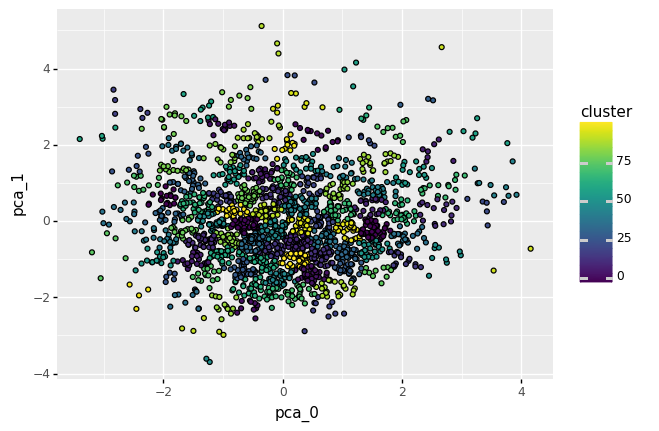

<ggplot: (8764200203617)>

In [420]:
km = KMeans(n_clusters = 100)
km.fit(spotify_pca)

membership = km.predict(spotify_pca)

spotify_pca['cluster'] = membership

spotify_pca = spotify_pca.rename({1 : 'pca_1', 0 : 'pca_0'}, axis = 1)
ggplot(spotify_pca, aes(x = 'pca_0', y = 'pca_1', fill = 'cluster')) + geom_point()

In [421]:
silhouette_score(spotify_pca, membership)

0.8692117858411651

### Optimizing parameters for K-Means model

In [422]:
#finding the best value for K (number of clusters)
ks = [2,5,10,20,30,50,75,100,125,150,200]

sse = []
sils = []

for k in ks:
    km = KMeans(n_clusters = k)
    km.fit(spotify_pca)
    
    sse.append(km.inertia_)
    sils.append(silhouette_score(spotify_pca, km.predict(spotify_pca)))
    
sse_df = pd.DataFrame({'K': ks, 'sse': sse, 'silhouette': sils})

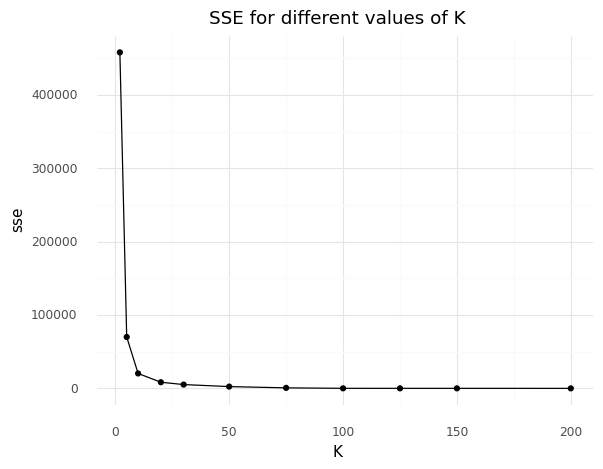

<ggplot: (8764197866000)>

In [423]:
(ggplot(sse_df, aes(x = 'K', y = 'sse')) + 
geom_point() + 
geom_line() + 
theme_minimal() +
labs(title = 'SSE for different values of K'))

### The higher the value of K, the lower the sum of squared errors becomes. After a K value of 50 there is not a noticable difference in sse.

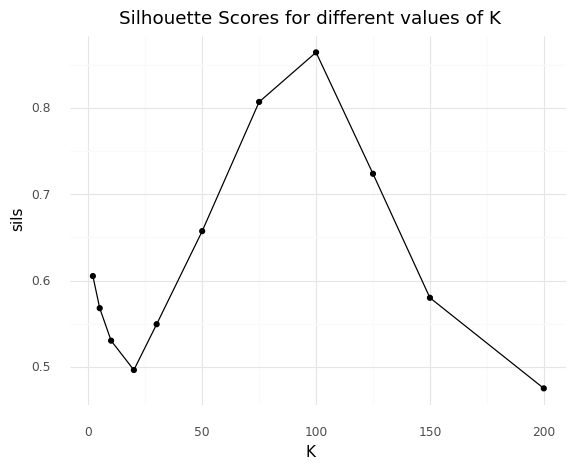

<ggplot: (8764197730570)>

In [424]:
(ggplot(sse_df, aes(x = 'K', y = 'sils')) + 
geom_point() + 
geom_line() + 
theme_minimal() +
labs(title = 'Silhouette Scores for different values of K'))

### K = 100 is produces the highest silhouette score

# Results

In [425]:
#appending song title and artist to the database
spotify_pca['song_title'] = spotify['song_title']
spotify_pca['artist'] = spotify['artist']

spotify_pca

,pca_0,pca_1,cluster,song_title,artist
0,-1.201027,-0.257704,48,Mask Off,Future
1,-1.173836,-0.212067,48,Redbone,Childish Gambino
2,-1.404712,-1.001239,8,Xanny Family,Future
3,-0.482608,-0.196735,2,Master Of None,Beach House
4,-1.243111,2.639905,6,Parallel Lines,Junior Boys
...,...,...,...,...,...
2012,0.542879,-0.798194,14,Like A Bitch - Kill The Noise Remix,Kill The Noise
2013,-0.974040,-2.190594,84,Candy,Dillon Francis
2014,1.370950,-0.943177,52,Habit - Dack Janiels & Wenzday Remix,Rain Man
2015,1.150580,-0.050074,95,First Contact,Twin Moons


In [427]:
#takes input from the user and returns reccomendations
def getReccomendations():
    
    num_cluster = 0
    
    #takes input from user
    print('Enter the name of an artist')
    artist = input(str('>> '))
    print('Eter the name of their song')
    song = input(str('>> '))

    #finds cluster value of song
    try:
        for i in range(len(spotify_pca)):
            if spotify_pca['artist'].iloc[i] == artist and spotify_pca['song_title'].iloc[i] == song:
                num_cluster = spotify_pca['cluster'].iloc[i]
    except KeyError:
        print('Error: Artist/Song not in database')
    #outputs all songs in the cluster
    finally:
        for i in range(len(spotify_pca)):
            if spotify_pca['cluster'].iloc[i] == num_cluster:
                print(spotify_pca['artist'].iloc[i], ', ', spotify_pca['song_title'].iloc[i])
                
getReccomendations()

Enter the name of an artist
>> Childish Gambino
Eter the name of their song
>> Redbone
Future ,  Mask Off
Childish Gambino ,  Redbone
Drake ,  Sneakin’
Le Youth ,  C O O L - Radio Edit
Ty Dolla $ign ,  Blasé (feat. Future & Rae Sremmurd)
Young Thug ,  Best Friend
T. P. Orchestre Poly-Rythmo ,  Azon de ma gnin kpevi
Ariel Pink's Haunted Graffiti ,  Baby
Hermitude ,  The Buzz (feat. Mataya & Young Tapz)
Blood Orange ,  Uncle ACE
Depeche Mode ,  Enjoy The Silence - Remastered Version Original
OB OBrien ,  Hazelton Trump
HS87 ,  Grindin’ My Whole Life
!!! ,  Slyd
Hanni El Khatib ,  Dead Wrong
Discovery ,  Osaka Loop Line
Hot Chip ,  Night And Day
A-Trak ,  Piss Test (feat. Juicy J & Dany Brown)
Grum ,  Can't Shake This Feeling
Beach House ,  Walk In The Park
The Partysquad ,  For Your Love - Club Edit
Juicy J ,  Bounce It
Drake ,  Hold On, We're Going Home
Riff Raff ,  Marc Jacobs
Drake ,  Hold On, We're Going Home
Hoodfellas ,  Independent - House Remix
T. Rex ,  Bang A Gong [Get It On] (